# Analysis of Real Data from the PDHD Detector
## **This notebook focuses on the run 32974, collection plane.**
Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector. 

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. For these data dead channels (overactivity with no real physical signal) have already been masked.

In [20]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [21]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [22]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [23]:
#In this notebook we will try to do some more statystics and use all of them
events = df_32974.event.unique()
print(f"Event {events}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [24]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [25]:
plane=2

def make_title(run, event, cuts="no cuts"):
    return f"Run {run} | Event {event} | Plane {plane} | {cuts}"

### Characteristics of a single run, single event, collection plane hits of a single TPC. 

In [26]:
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974
tps_32974.run_name = "Cosmic run 32974"

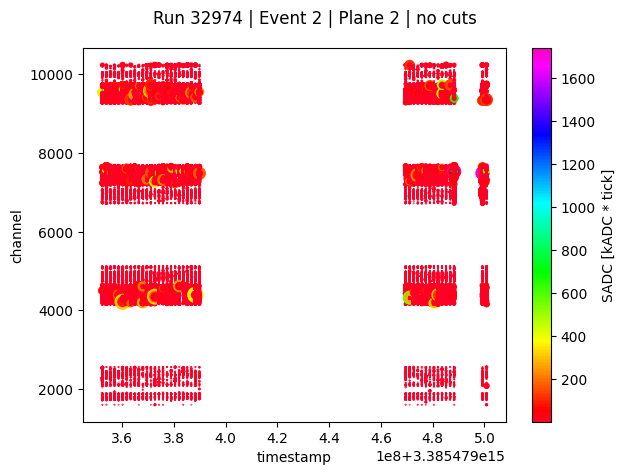

In [27]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
tps.run_name = "Cosmic run 32974"
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(make_title(tps['run'].unique()[0], plane))
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [28]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 3476.412, mean 4.431609466048282, std deviation 26.564154887469076
TP_PeakADC: Minimum value 61, maximum 15886, mean 393.2983097260657, std deviation 445.1967497902622
TP_TOT: Minimum value 1, maximum 1171, mean 13.815287995808866, std deviation 18.607527684417374


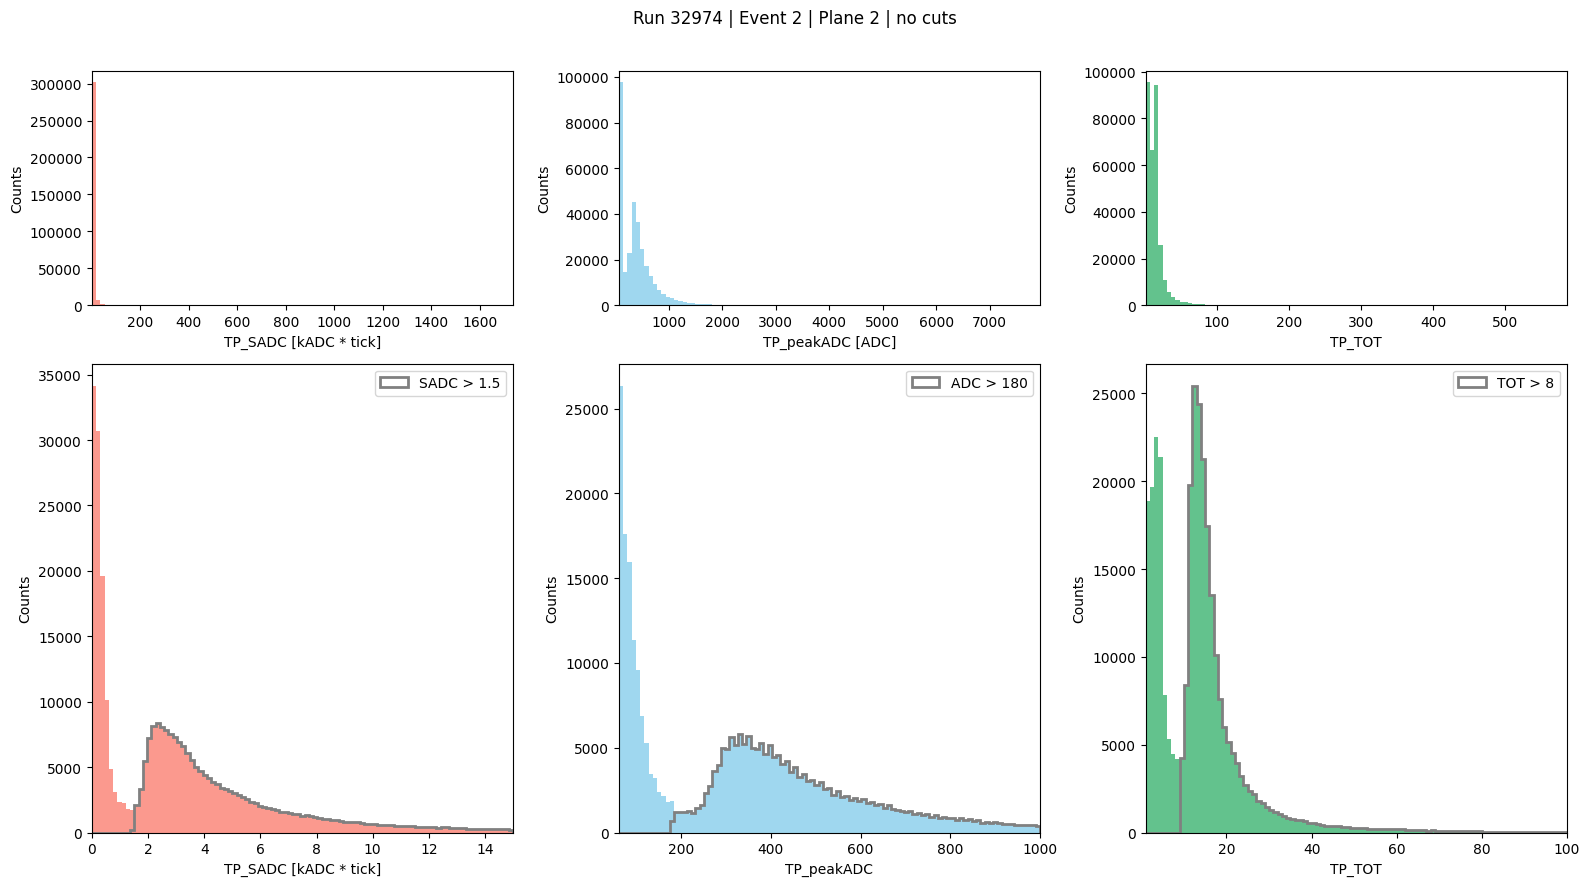

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(make_title(tps['run'].unique()[0], plane))

# 1. TP_SADC
bins_sadc = np.linspace(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3, 100)
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=bins_sadc, alpha=0.8, color='salmon')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].set_xlim(bins_sadc[0], bins_sadc[-1])

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 15)
tps_zoom_sadc = tps[mask_sadc]
bins_sadc_zoom = np.linspace(0, 15, 100)
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=bins_sadc_zoom, alpha=0.8, color='salmon')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(bins_sadc_zoom[0], bins_sadc_zoom[-1])

threshold_sadc = 1.5
sadc_cut = tps_zoom_sadc[tps_zoom_sadc['TP_SADC']/1e3 > threshold_sadc]
axs[1, 0].hist(sadc_cut['TP_SADC']/1e3, bins=bins_sadc_zoom, histtype='step', color='gray', linewidth=2, label='SADC > 1.5')
axs[1, 0].legend()

# 2. TP_peakADC
bins_adc = np.linspace(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2, 100)
axs[0, 1].hist(tps['TP_peakADC'], bins=bins_adc, alpha=0.8, color='skyblue')
axs[0, 1].set_xlabel('TP_peakADC [ADC]')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(bins_adc[0], bins_adc[-1])

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
bins_adc_zoom = np.linspace(61, 1000, 100)
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=bins_adc_zoom, alpha=0.8, color='skyblue')
axs[1, 1].set_xlabel('TP_peakADC')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(bins_adc_zoom[0], bins_adc_zoom[-1])

threshold_adc = 180
adc_cut = tps_zoom_adc[tps_zoom_adc['TP_peakADC'] > threshold_adc]
axs[1, 1].hist(adc_cut['TP_peakADC'], bins=bins_adc_zoom, histtype='step', color='gray', linewidth=2, label='ADC > 180')
axs[1, 1].legend()

# 3. TP_TOT
bins_tot = np.linspace(tps['TP_TOT'].min(), tps['TP_TOT'].max()/2, 100)
axs[0, 2].hist(tps['TP_TOT'], bins=bins_tot, alpha=0.8, color='mediumseagreen')
axs[0, 2].set_xlabel('TP_TOT')
axs[0, 2].set_ylabel('Counts')
axs[0, 2].set_xlim(bins_tot[0], bins_tot[-1])

mask_tot = (tps['TP_TOT'] >= 1) & (tps['TP_TOT'] <= 100)
tps_zoom_tot = tps[mask_tot]
bins_tot_zoom = np.linspace(1, 100, 100)
axs[1, 2].hist(tps_zoom_tot['TP_TOT'], bins=bins_tot_zoom, alpha=0.8, color='mediumseagreen')
axs[1, 2].set_xlabel('TP_TOT')
axs[1, 2].set_ylabel('Counts')
axs[1, 2].set_xlim(bins_tot_zoom[0], bins_tot_zoom[-1])

threshold_tot = 8
tot_cut = tps_zoom_tot[tps_zoom_tot['TP_TOT'] > threshold_tot]
axs[1, 2].hist(tot_cut['TP_TOT'], bins=bins_tot_zoom, histtype='step', color='gray', linewidth=2, label='TOT > 8')
axs[1, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

    Apparently the same cuts we used for one single event work in this case

Event duration: 1.6919 s


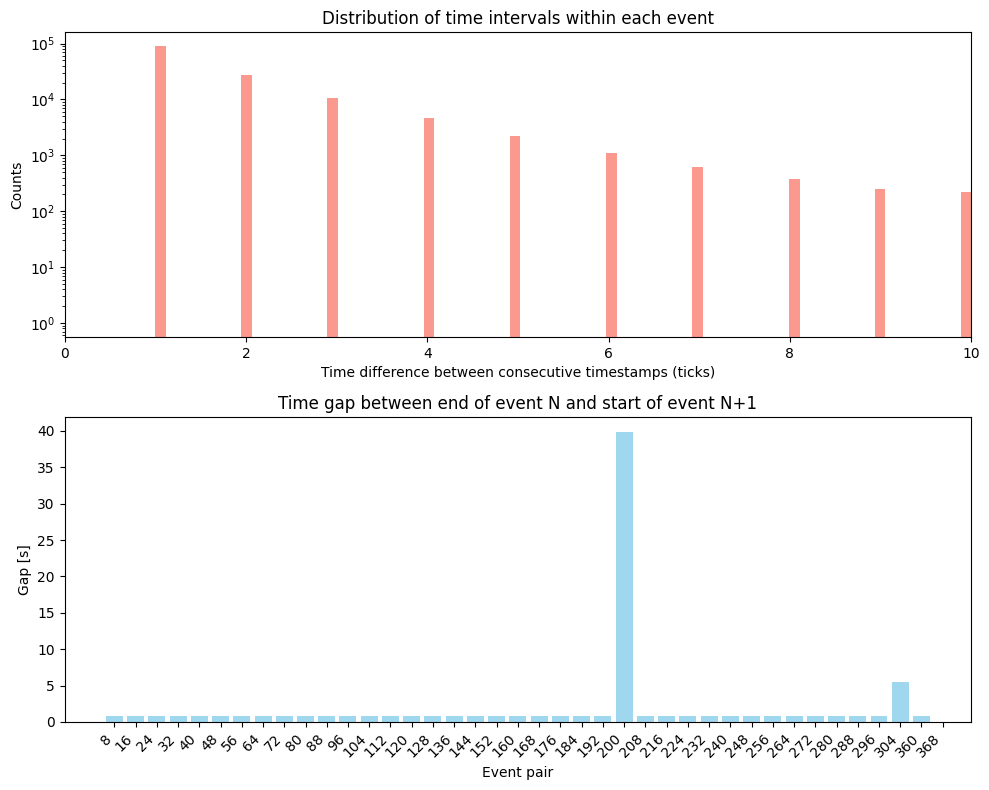

In [30]:
# Store intra-event intervals and inter-event gaps
intra_event_diffs = []
event_firsts = []
event_lasts = []
event_durations_seconds = []

for ev in events:
    ev_df = tps[tps.event == ev]
    ts = np.sort(ev_df["TP_peakT"].unique())
    if len(ts) > 1:
        intra_event_diffs.append(np.diff(ts))
        duration_ticks = ts.max() - ts.min()
        duration_seconds = duration_ticks * 500 / 1e9 #each tick corresponds to 500 ns
        event_durations_seconds.append(duration_seconds)
    event_firsts.append(ts[0])
    event_lasts.append(ts[-1])

# Flatten intra-event diffs for global histogram
intra_event_flat = np.concatenate(intra_event_diffs)

# Compute inter-event gaps
event_firsts = np.array(event_firsts)
event_lasts = np.array(event_lasts)
inter_event_gaps = event_firsts[1:] - event_lasts[:-1]
inter_event_gaps_seconds = inter_event_gaps * 500 / 1e9

print(f"Event duration: {np.mean(intra_event_flat):.4f} s")

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].hist(intra_event_flat, bins=int(2*np.sqrt(len(intra_event_flat))), color='salmon', alpha=0.8, log=True) #y axis in log scale
axs[0].set_title('Distribution of time intervals within each event')
axs[0].set_xlabel('Time difference between consecutive timestamps (ticks)')
axs[0].set_ylabel('Counts')
axs[0].set_xlim(0, 10)

# Bar plot with custom labels for event pairs
axs[1].bar(range(len(inter_event_gaps_seconds)), inter_event_gaps_seconds, color='skyblue', alpha=0.8)
axs[1].set_title('Time gap between end of event N and start of event N+1')
axs[1].set_xlabel('Event pair')
axs[1].set_ylabel('Gap [s]')
axs[1].set_xticks(range(len(events)))
axs[1].set_xticklabels(events, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Looking into thresholds and noise removal

In [31]:
def plot_TPC_activity(tp_df, thresh, thresh_type="TP_peakADC", vmin=None, vmax=None, show_counts=True):  
    """
    Creates scatter plots showing TP distribution across APAs with optional bar charts for TP counts. 
    Scatter plot point sizes are proportional to TP_TOT/10. Scatter plot colors represent TP_SADC values using 'gist_rainbow' colormap
    Data is filtered based on specified threshold criteria to remove noise.
    Creates 2x2 subplot grid for the 4 APAs in ProtoDUNE. Requires global variable 'apa_ranges' containing APA channel ranges

    ----------
    tp_df : pandas.DataFrame
        DataFrame containing trigger primitive data
        
    thresh : float
        Threshold value for filtering TPs. 
        
    thresh_type : str, optional
        Type of threshold to apply for filtering. Default is "TP_peakADC".
        Options:
        - "TP_peakADC": Filter by peak ADC value
        - "TP_TOT": Filter by time over threshold
        - "TP_SADC": Filter by sum ADC (divided by 1e3 for kADC units)
        
    vmin : float, optional
        Minimum value for colorbar scale in scatter plots. If None, uses data minimum.
        
    vmax : float, optional
        Maximum value for colorbar scale in scatter plots. If None, uses data maximum.
        
    show_counts : bool, optional
        Whether to display bar chart showing TP counts per APA. Default is True.
    """
    global apa_ranges 
    title_prefix = "TP Activity per APA"
    # Filter based on the threshold type
    if thresh_type == "TP_peakADC":
        filtered = tp_df[tp_df.TP_peakADC > thresh]
    elif thresh_type == "TP_TOT":
        filtered = tp_df[tp_df.TP_TOT > thresh]
    elif thresh_type == "TP_SADC":
        filtered = tp_df[tp_df.TP_SADC / 1e3 > thresh]
    else:
        raise ValueError(f"Unknown threshold type: {thresh_type}")

    print(f"Threshold ({thresh_type}): {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name if hasattr(tp_df, 'run_name') else "unknown_run"
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh_type} > {thresh})"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC,
            cmap="gist_rainbow",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color='steelblue')
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({thresh_type} > {thresh})")
        plt.show()

Threshold (TP_SADC): 1.5 (TPs: 17103, Retaining 67.33% of raw TP)


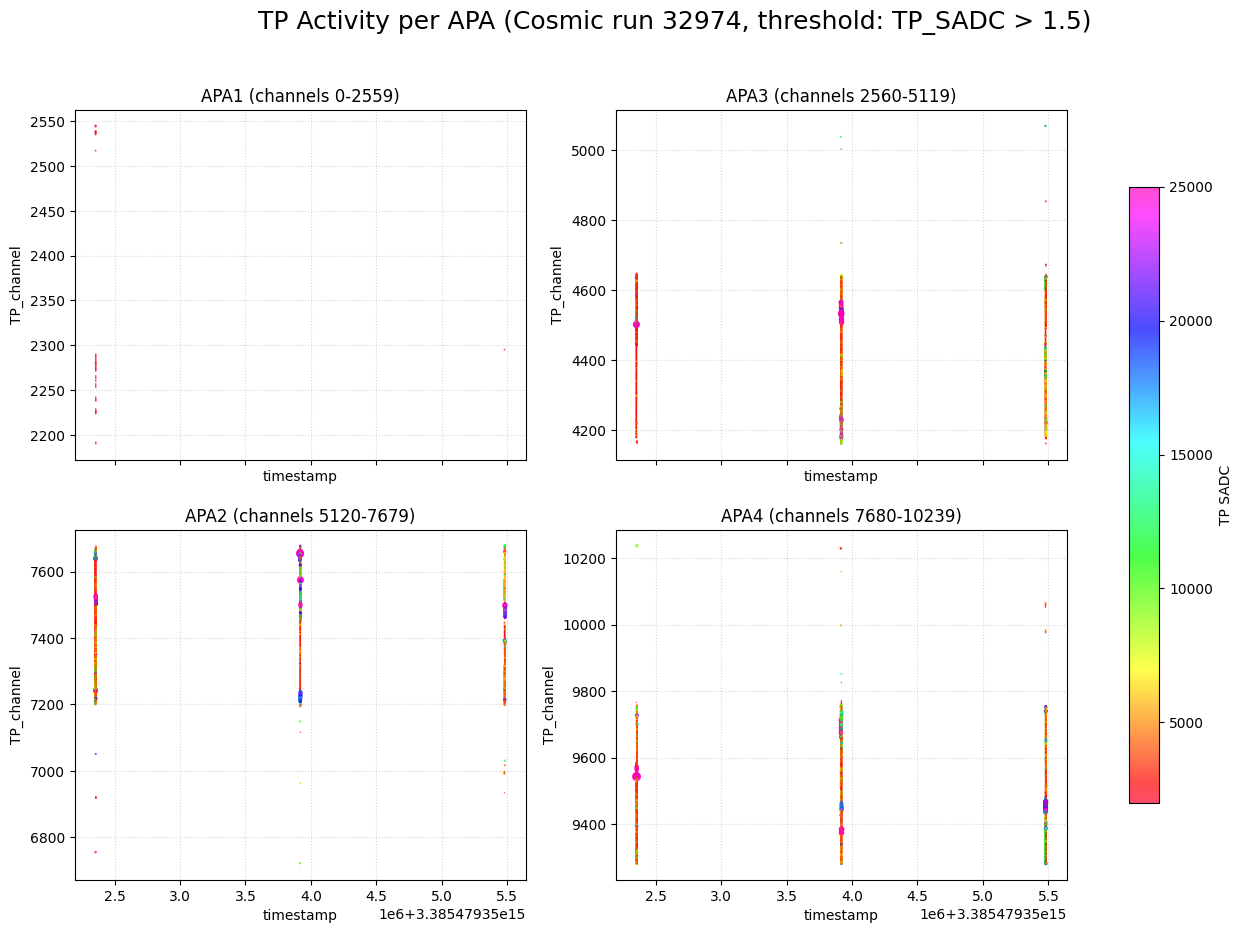

Threshold (TP_peakADC): 180 (TPs: 17406, Retaining 68.53% of raw TP)


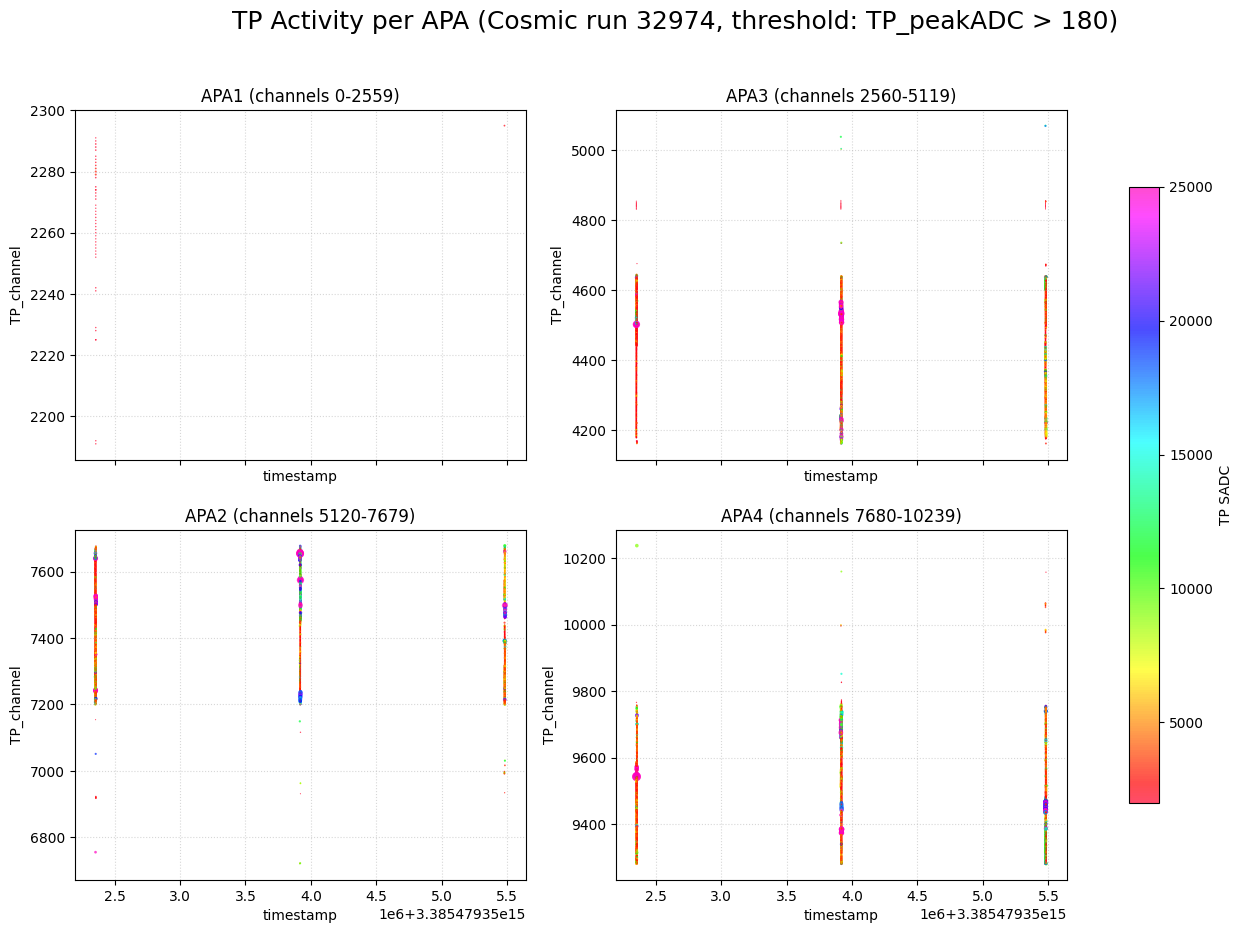

Threshold (TP_TOT): 8 (TPs: 17510, Retaining 68.94% of raw TP)


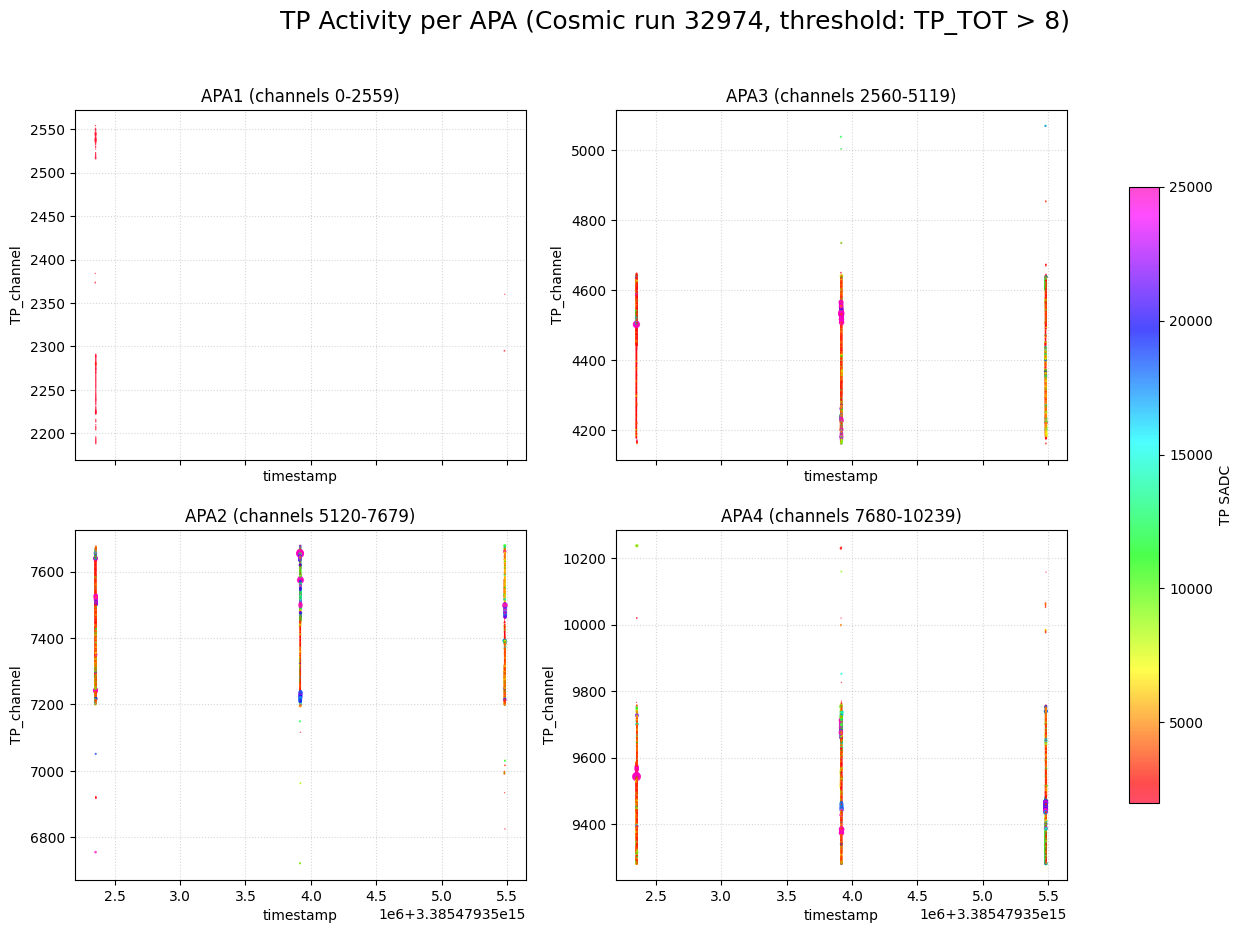

In [32]:
mask = (tps['event'] < 25)
tps_subset = tps[mask]
tps_subset.run_name = tps.run_name

# For SADC threshold
plot_TPC_activity(tps_subset, threshold_sadc, 
            vmin=2000, vmax=25000, thresh_type="TP_SADC", show_counts=False)

# For ADC threshold
plot_TPC_activity(tps_subset, threshold_adc, 
            vmin=2000, vmax=25000, thresh_type="TP_peakADC", show_counts=False)

# For TOT threshold
plot_TPC_activity(tps_subset, threshold_tot, 
            vmin=2000, vmax=25000, thresh_type="TP_TOT", show_counts=False)

- Big dots are just particles perpedincular to one single channel and therefore releasing a lot of energy in that single channel.
- Because the peakT are so different it's impossible to see any tracks inside the events

### Spatial distribution

In [62]:
filtered_tps= tps_subset[tps_subset.TP_SADC / 1e3 > threshold_sadc]
filtered_APA2=filtered_tps[(filtered_tps.TP_channel>=apa_ranges["APA2"][0]) & (filtered_tps.TP_channel<apa_ranges["APA2"][1])]
filtered_APA2.run_name = tps.run_name

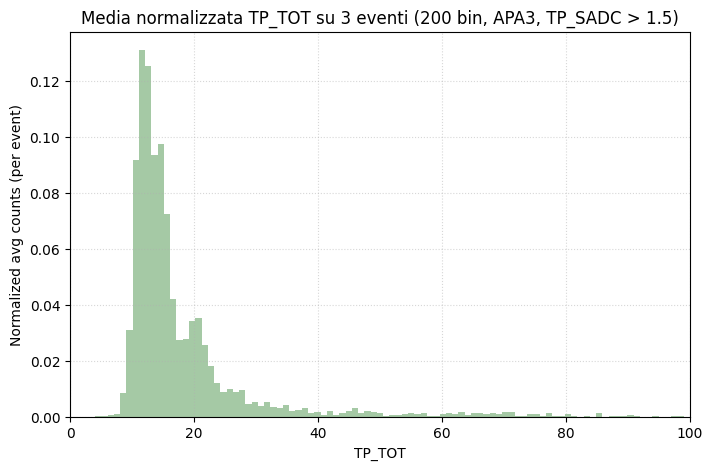

In [63]:
"""
Event-by-Event TP_TOT Distribution Analysis for APA3

This cell performs a detailed statistical analysis of Time Over Threshold (TP_TOT) distributions across multiple cosmic ray events in APA3.

Analysis Strategy:
-----------------
Instead of combining all TP_TOT values from multiple events into a single histogram (which can
smooth out important features), this analysis:

1. Calculates individual normalized histograms for each event
2. Computes the average normalized distribution across all events
3. Creates a 2D heatmap showing TP_TOT distributions per event

Motivation:
---------------------
- Different cosmic ray events may be dominated by different track types or signal populations: aggregating all TP_TOT values can lead to merging and overlapping peaks, 
resulting in a smoother distribution that obscures distinct features.
- This approach wants to reveal common structural features across events

Binning: 200 bins from 0 to 100 TP_TOT units for high resolution
"""

events = np.sort(filtered_APA2['event'].unique())
bins = np.linspace(0, 100, 100)  # 200 bin da 0 a 100
#: in alcuni eventi possono dominare certe tracce o tipologie di segnali che producono un picco, in altri eventi un’altra popolazione. 
# Sommando tutto, i picchi possono “mescolarsi” e sovrapporsi, risultando in una distribuzione più smooth e larga senza due massimi evidenti.

# ================= TP_TOT =================
# Invece di sommare tutte le TP_TOT di 88 eventi insieme, calcola la distribuzione per ogni evento e poi somma (“stacked histogram”) o fai la media delle distribuzioni normalizzate.
# Questo evita che eventi molto “ricchi” dominino la statistica, e fa emergere strutture comuni.
all_event_histos_tot = []
for ev in events:
    dat = filtered_APA2[filtered_APA2['event'] == ev]['TP_TOT']
    counts, _ = np.histogram(dat, bins=bins)
    if counts.sum() > 0:
        counts = counts / counts.sum()
    all_event_histos_tot.append(counts)
mean_histo_tot = np.mean(all_event_histos_tot, axis=0)

plt.figure(figsize=(8,5))
plt.bar((bins[:-1]+bins[1:])/2, mean_histo_tot, width=np.diff(bins), color='darkseagreen', alpha=0.8)
plt.xlabel("TP_TOT")
plt.ylabel("Normalized avg counts (per event)")
plt.title(f"Media normalizzata TP_TOT su {len(events)} eventi (200 bin, APA3, TP_SADC > {threshold_sadc})")
plt.xlim(0, 100)
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

Most of the events seem to be between 11-18, the bimodial distribution that is clear in the case of **RUN_test_event_run.ipynb** is not visibile over here.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

events = np.unique(filtered_APA2['event'])

# Define parameter grid
eps_grid = np.arange(5, 100, 25)         # Example: from 5 to 95 in steps of 5
min_samples_grid = np.arange(2, 20, 1)   # Example: from 2 to 7

results = []

for ev in events:
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    # Optional: normalize TP_peakT for each event
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min()
    X = sel[['TP_peakT', 'TP_channel']].values

    best_score = -1
    best_params = None
    best_n_clusters = None

    for eps in eps_grid:
        for min_samples in min_samples_grid:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            labels = db.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            # Silhouette is defined only if there are at least 2 clusters (excluding noise)
            if n_clusters > 1:
                try:
                    score = metrics.silhouette_score(X, labels)
                except Exception:
                    score = -1
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_n_clusters = n_clusters
    results.append({
        "event": ev,
        "best_eps": best_params[0] if best_params else None,
        "best_min_samples": best_params[1] if best_params else None,
        "best_score": best_score if best_score > -1 else None,
        "n_clusters": best_n_clusters if best_n_clusters else None,
    })

# Show full summary table
results_df = pd.DataFrame(results)
print("\nSummary table of best DBSCAN hyperparameters per event:")
print(results_df)


Summary table of best DBSCAN hyperparameters per event:
   event  best_eps  best_min_samples  best_score  n_clusters
0      8        80                16    0.553574           6
1     16        80                14    0.602473           4
2     24        55                14    0.473404           5


Are events unique? True
Silhouette (event 8): 0.5535634574613782
Silhouette (event 16): 0.6010097901225165
Silhouette (event 24): 0.41708802607472834


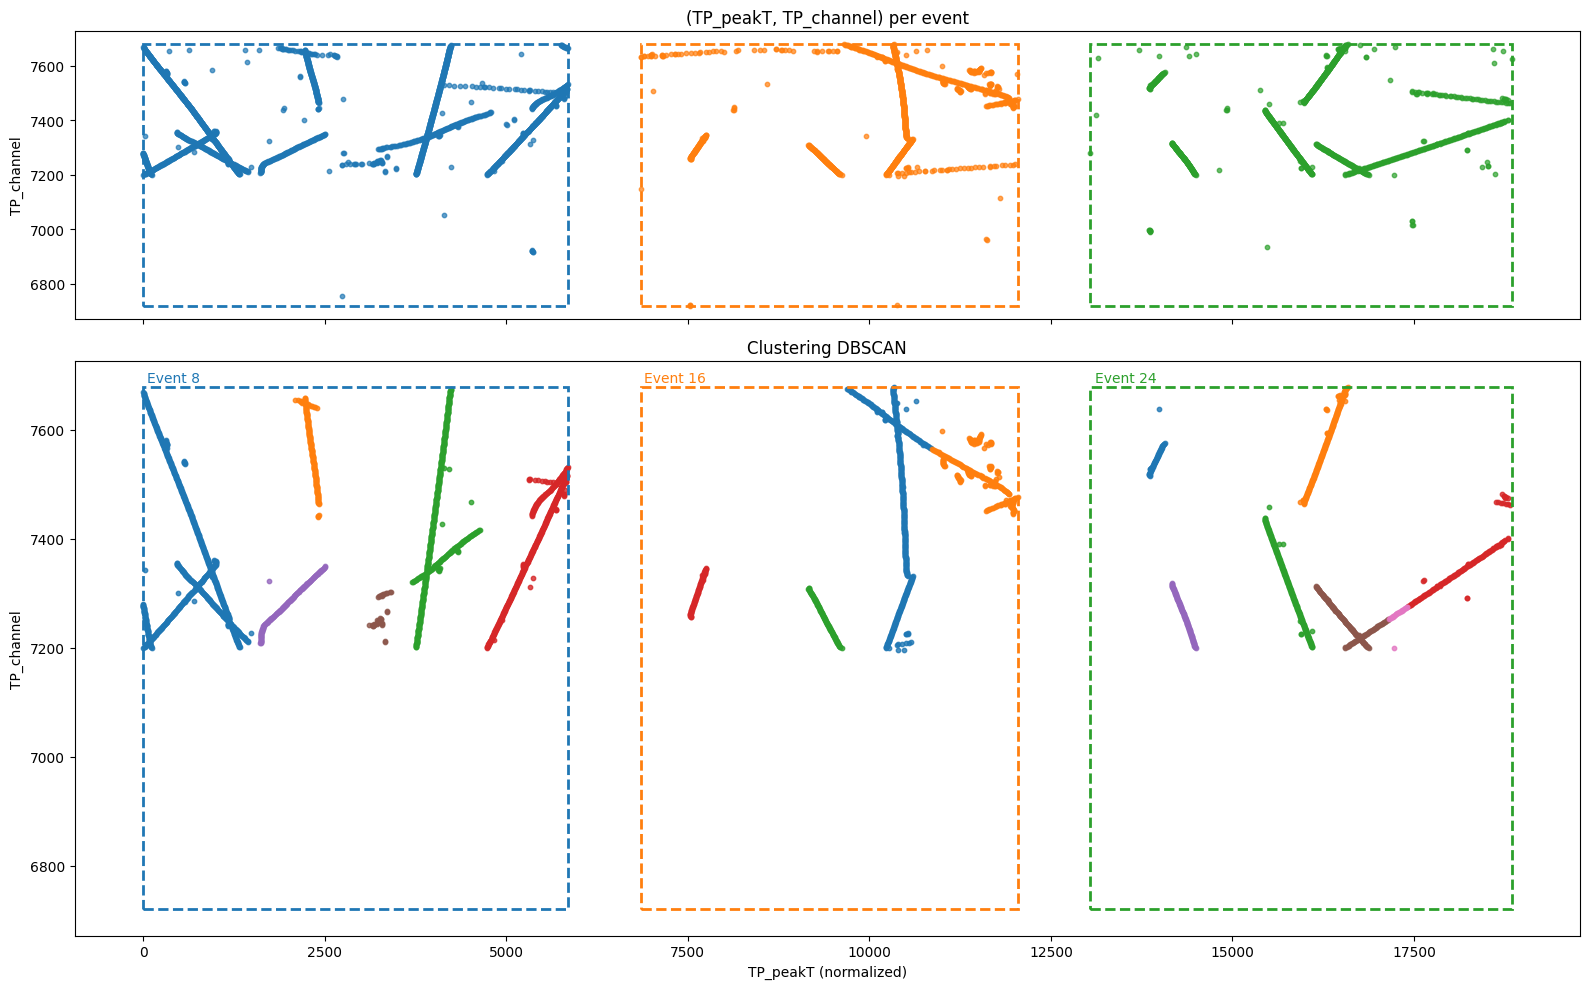

In [ ]:
from matplotlib.patches import Rectangle
events = np.unique(filtered_APA2['event'])
print("Are events unique?", len(events) == len(set(events)))

fig, axs = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [1,2]})

# Variabili per offset e limiti
offset = 0
ymin = filtered_APA2['TP_channel'].min()
ymax = filtered_APA2['TP_channel'].max()
colors = plt.cm.tab10.colors

# --- SUBPLOT SOPRA: solo punti senza clustering ---
offset = 0
for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    axs[0].scatter(sel['TP_peakT'], sel['TP_channel'], s=10, alpha=0.7, color=colors[i % 10], label=f'Event {ev}')
    
    # Rettangolo evento
    rect = Rectangle((tmin, ymin), tmax-tmin, ymax-ymin, linewidth=2, edgecolor=colors[i % 10], facecolor='none', linestyle='--')
    axs[0].add_patch(rect)
    offset += tmax - tmin + 1000

axs[0].set_ylabel('TP_channel')
axs[0].set_title('(TP_peakT, TP_channel) per event')

# --- SUBPLOT SOTTO: clustering e rettangoli ---
offset = 0
for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy() # single event selection

    #this is to normalize the TP_peakT values for better visualization
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()

    # Clustering
    X = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=80, min_samples=15).fit(X)
    sel['cluster'] = db.labels_
    labels = sel['cluster']

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        print(f'Silhouette (event {ev}): {metrics.silhouette_score(X, labels)}')
    else:
        print(f'Silhouette (event {ev}): N/A (only one cluster or all noise)')

    # Punti per cluster
    for c in np.unique(sel['cluster']):
        if c == -1: continue
        sub = sel[sel['cluster'] == c]
        axs[1].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.8, color=colors[c % 10])

    # this rectangle makes the visualization easier
    rect = Rectangle((tmin, ymin), tmax-tmin, ymax-ymin, linewidth=2, edgecolor=colors[i % 10], facecolor='none', linestyle='--')
    axs[1].add_patch(rect)
    axs[1].text(tmin + (tmax-tmin)*0.01, ymax+30, f'Event {ev}', fontsize=10, color=colors[i % 10], va='top')
    offset += tmax - tmin + 1000

axs[1].set_xlabel('TP_peakT (normalized)')
axs[1].set_ylabel('TP_channel')
axs[1].set_title('Clustering DBSCAN')
plt.tight_layout()
plt.show()

Are events unique? True
Silhouette (event 8): 0.5535634574613782
Silhouette (event 16): 0.6010097901225165
Silhouette (event 24): 0.41708802607472834


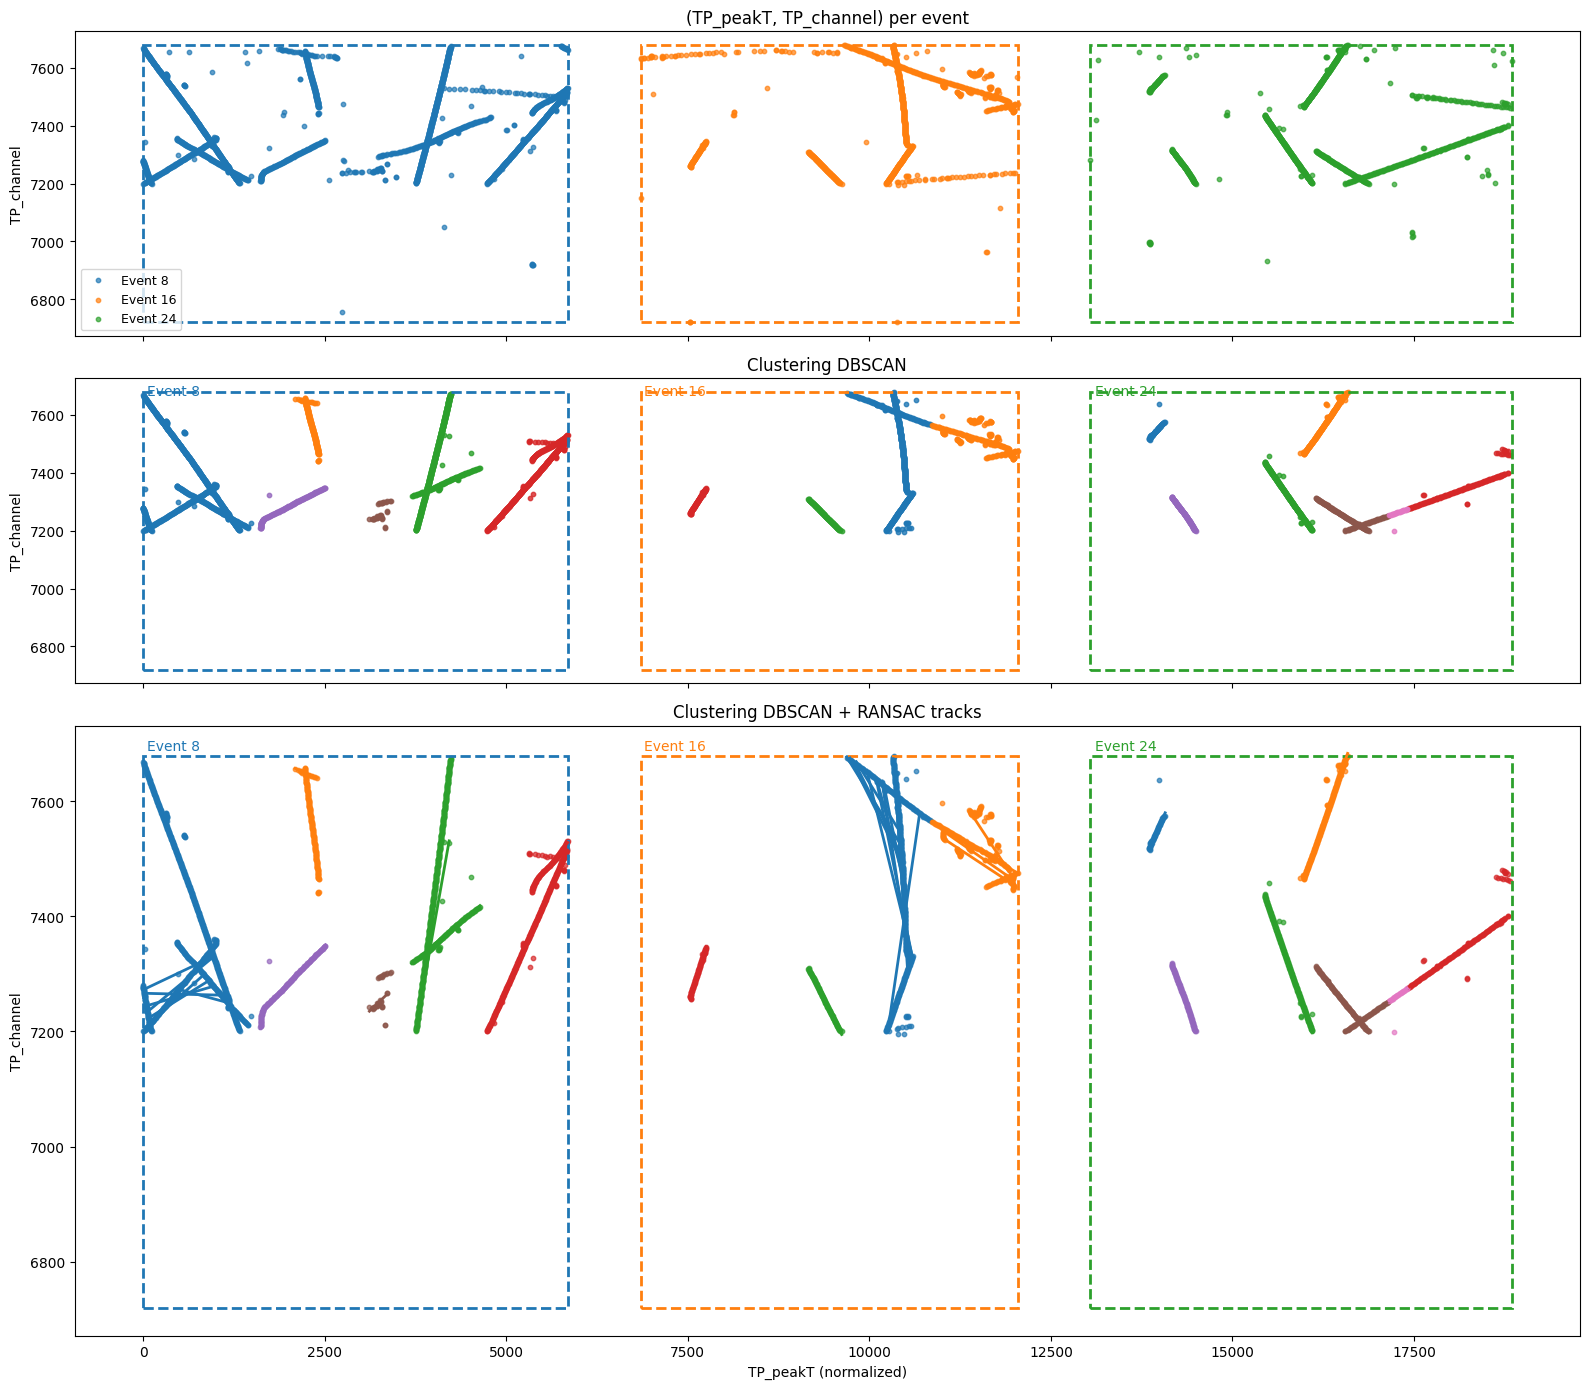

In [94]:
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn import metrics
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt

events = np.unique(filtered_APA2['event'])
print("Are events unique?", len(events) == len(set(events)))

fig, axs = plt.subplots(3, 1, figsize=(16, 14), sharex=True, gridspec_kw={'height_ratios': [1,1,2]})

offset = 0
ymin = filtered_APA2['TP_channel'].min()
ymax = filtered_APA2['TP_channel'].max()
colors = plt.cm.tab10.colors

# --- SUBPLOT 1: Only raw points, no clustering ---
offset = 0
for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    axs[0].scatter(sel['TP_peakT'], sel['TP_channel'], s=10, alpha=0.7, color=colors[i % 10], label=f'Event {ev}')
    rect = Rectangle((tmin, ymin), tmax-tmin, ymax-ymin, linewidth=2, edgecolor=colors[i % 10], facecolor='none', linestyle='--')
    axs[0].add_patch(rect)
    offset += tmax - tmin + 1000
axs[0].set_ylabel('TP_channel')
axs[0].set_title('(TP_peakT, TP_channel) per event')
axs[0].legend(fontsize=9)

# --- SUBPLOT 2: Clusters and event boxes ---
offset = 0
for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    X = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=80, min_samples=15).fit(X)
    sel['cluster'] = db.labels_
    labels = sel['cluster']
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        print(f'Silhouette (event {ev}): {metrics.silhouette_score(X, labels)}')
    else:
        print(f'Silhouette (event {ev}): N/A (only one cluster or all noise)')

    for c in np.unique(sel['cluster']):
        if c == -1: continue
        sub = sel[sel['cluster'] == c]
        axs[1].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.8, color=colors[c % 10])
    rect = Rectangle((tmin, ymin), tmax-tmin, ymax-ymin, linewidth=2, edgecolor=colors[i % 10], facecolor='none', linestyle='--')
    axs[1].add_patch(rect)
    axs[1].text(tmin + (tmax-tmin)*0.01, ymax+30, f'Event {ev}', fontsize=10, color=colors[i % 10], va='top')
    offset += tmax - tmin + 1000
axs[1].set_ylabel('TP_channel')
axs[1].set_title('Clustering DBSCAN')

# --- SUBPLOT 3: Clusters with RANSAC tracks and event boxes ---
offset = 0
min_points_line = 12         # Minimum inliers for a track, adjust as needed
residual_threshold = 5     # RANSAC residual threshold, adjust as needed
max_trials = 50

for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    X = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=80, min_samples=15).fit(X)
    sel['cluster'] = db.labels_
    
    for c in np.unique(sel['cluster']):
        if c == -1: continue  # skip noise
        sub = sel[sel['cluster'] == c]
        pts = sub[['TP_peakT', 'TP_channel']].values
        axs[2].scatter(pts[:,0], pts[:,1], s=10, alpha=0.7, color=colors[c % 10])
        # --- RANSAC pattern recognition for multiple tracks per cluster ---
        cluster_points = pts.copy()
        tracks_found = 0
        while len(cluster_points) >= min_points_line:
            model = RANSACRegressor(LinearRegression(), residual_threshold=residual_threshold, min_samples=min_points_line,max_trials=max_trials)
            model.fit(cluster_points[:,0].reshape(-1,1), cluster_points[:,1])
            inlier_mask = model.inlier_mask_
            if np.sum(inlier_mask) < min_points_line:
                break
            # Plot only on the inlier range
            x_in = cluster_points[:,0][inlier_mask]
            x_fit = np.linspace(x_in.min(), x_in.max(), 100)
            y_fit = model.predict(x_fit.reshape(-1,1))
            axs[2].plot(x_fit, y_fit, '-', color=colors[c % 10], linewidth=2)
            tracks_found += 1
            # Remove inliers and continue
            cluster_points = cluster_points[~inlier_mask]
    rect = Rectangle((tmin, ymin), tmax-tmin, ymax-ymin, linewidth=2, edgecolor=colors[i % 10], facecolor='none', linestyle='--')
    axs[2].add_patch(rect)
    axs[2].text(tmin + (tmax-tmin)*0.01, ymax+30, f'Event {ev}', fontsize=10, color=colors[i % 10], va='top')
    offset += tmax - tmin + 1000

axs[2].set_xlabel('TP_peakT (normalized)')
axs[2].set_ylabel('TP_channel')
axs[2].set_title('Clustering DBSCAN + RANSAC tracks')
plt.tight_layout()
plt.show()

In [91]:
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor, Ridge
import numpy as np

alphas = [0.01, 0.1, 1, 10]
results = []

for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    X_full = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=80, min_samples=15).fit(X_full)
    sel['cluster'] = db.labels_
    
    for c in np.unique(sel['cluster']):
        if c == -1: continue  # skip noise
        sub = sel[sel['cluster'] == c]
        pts = sub[['TP_peakT', 'TP_channel']].values
        if len(pts) < 20:  # skip tiny clusters
            continue
        X = pts[:,0].reshape(-1,1)
        y = pts[:,1]
        best_score = -np.inf
        best_alpha = None
        for alpha in alphas:
            model = RANSACRegressor(
                Ridge(alpha=alpha),
                residual_threshold=8,
                min_samples=12,
                random_state=0
            )
            model.fit(X, y)
            inlier_mask = model.inlier_mask_
            if np.sum(inlier_mask) < 5:
                continue
            score = model.score(X[inlier_mask], y[inlier_mask])
            if score > best_score:
                best_score = score
                best_alpha = alpha
        print(f"Event {ev} Cluster {c}: best alpha={best_alpha}, score={best_score:.3f}")
        results.append({'event': ev, 'cluster': c, 'best_alpha': best_alpha, 'best_score': best_score})

Event 8 Cluster 0: best alpha=0.01, score=1.000
Event 8 Cluster 1: best alpha=0.01, score=0.998
Event 8 Cluster 2: best alpha=0.01, score=1.000
Event 8 Cluster 3: best alpha=0.01, score=0.999
Event 8 Cluster 4: best alpha=0.01, score=0.995
Event 8 Cluster 5: best alpha=0.01, score=0.886
Event 16 Cluster 0: best alpha=10, score=0.998
Event 16 Cluster 1: best alpha=0.1, score=0.978
Event 16 Cluster 2: best alpha=0.01, score=1.000
Event 16 Cluster 3: best alpha=0.01, score=0.995
Event 24 Cluster 0: best alpha=0.01, score=0.991
Event 24 Cluster 1: best alpha=0.01, score=0.999
Event 24 Cluster 2: best alpha=0.01, score=1.000
Event 24 Cluster 3: best alpha=0.01, score=1.000
Event 24 Cluster 4: best alpha=0.01, score=0.998
Event 24 Cluster 5: best alpha=0.01, score=0.998
Event 24 Cluster 6: best alpha=0.01, score=1.000


In [93]:
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor, Ridge
import numpy as np

# Define the grid for RANSAC parameters
residual_thresholds = [5, 8, 10, 15]
min_samples_list = [8, 12, 16]
max_trials_list = [50, 100, 200]

alphas = [1.0]  # You can grid search alpha for Ridge too if you like
results = []

for i, ev in enumerate(events):
    sel = filtered_APA2[filtered_APA2['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    X_full = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=80, min_samples=15).fit(X_full)
    sel['cluster'] = db.labels_
    
    for c in np.unique(sel['cluster']):
        if c == -1: continue  # skip noise
        sub = sel[sel['cluster'] == c]
        pts = sub[['TP_peakT', 'TP_channel']].values
        if len(pts) < max(min_samples_list):  # skip too small clusters
            continue
        X = pts[:,0].reshape(-1,1)
        y = pts[:,1]
        best_score = -np.inf
        best_params = None
        for residual_threshold in residual_thresholds:
            for min_samples in min_samples_list:
                for max_trials in max_trials_list:
                    for alpha in alphas:
                        model = RANSACRegressor(
                            Ridge(alpha=alpha),
                            residual_threshold=residual_threshold,
                            min_samples=min_samples,
                            max_trials=max_trials,
                            random_state=0
                        )
                        try:
                            model.fit(X, y)
                        except Exception:
                            continue  # skip failed fits
                        inlier_mask = model.inlier_mask_
                        if np.sum(inlier_mask) < min_samples:
                            continue
                        score = model.score(X[inlier_mask], y[inlier_mask])
                        if score > best_score:
                            best_score = score
                            best_params = (residual_threshold, min_samples, max_trials, alpha)
        results.append({
            'event': ev,
            'cluster': c,
            'best_residual_threshold': best_params[0] if best_params else None,
            'best_min_samples': best_params[1] if best_params else None,
            'best_max_trials': best_params[2] if best_params else None,
            'best_alpha': best_params[3] if best_params else None,
            'best_score': best_score
        })

df_results = pd.DataFrame(results)
print(df_results)

    event  cluster  best_residual_threshold  best_min_samples  \
0       8        0                        5                12   
1       8        1                        5                 8   
2       8        2                        5                 8   
3       8        3                        5                 8   
4       8        4                        5                 8   
5       8        5                        5                 8   
6      16        0                        5                16   
7      16        1                        5                16   
8      16        2                        5                 8   
9      16        3                        5                12   
10     24        0                        5                16   
11     24        1                        5                16   
12     24        2                        5                 8   
13     24        3                        5                 8   
14     24        4       